# Курсовой проект "Credit Default"

#### Задача

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

#### Метрика качества

F1-score (sklearn.metrics.f1_score)

#### Требования к решению

Целевая метрика

* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

In [1]:
#!pip install catboost

In [2]:
import functools as ft
import numpy as np
import pandas as pd

from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

import catboost as catb

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})  # размер шрифта на графиках

import warnings
warnings.filterwarnings('ignore')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def feature_encoding(val, tbl):
    """
    Возвращает индекс i из списка диапазонов tbl в который попадет значение val 
    """
    return ft.reduce((lambda i, e: (i if e > val else i+1)), tbl, 1)


In [5]:
class DataSet(pd.DataFrame):
    target_name = ''
    
    def __init__(self, df=None, train_path='', test_path='', sep=','):
        if (len(train_path) > 0) and (len(test_path) > 0):
            super().__init__(pd.concat([reduce_mem_usage(pd.read_csv(train_path, sep=sep)), 
                                        reduce_mem_usage(pd.read_csv(test_path, sep=sep))], 
                                        axis=0, keys=['train','test']))
            self.index.names=['Part', 'Id']
        elif not (df is None):
            super().__init__(df)

    @property
    def train(self):
        '''Возвращает тренировочный DataSet'''
        return DataSet(df=self.loc[['train'],])
 
    @property
    def test(self):
        '''Возвращает тестовый DataSet'''
        return DataSet(self.loc[['test'],])
    
    @property
    def target(self):
        '''Возвращает тренировочный DataSet только с целевой колонкой'''
        return DataSet(self.loc[['train'], DataSet.target_name])
    
    @property
    def num_feature_names(self):
        '''Возвращает список названий числовых колонок без целевой'''
        num_f=list(self.select_dtypes(include=['float64', 'float32', 'float16', 
                                               'int8', 'int16', 'int32', 'uint8']).columns)
        if num_f.count(DataSet.target_name) > 0:
            num_f.remove(DataSet.target_name)
        return num_f

    @property
    def num_features(self):
        '''Возвращает DataSet только с числовыми колонками без целевой'''
        return DataSet(self[self.num_feature_names])
    
    @property
    def msk_train(self):
        '''Возвращает маску с тренировочными записями'''
        return self.index.get_level_values('Part') == 'train'

    @property
    def msk_test(self):
        '''Возвращает маску с тестовыми записями'''
        return self.index.get_level_values('Part') == 'test'
    
    def msk_features_notnull(self, features):
        '''Возвращает маску с ненулевыми значениями в колонках features'''
        return ft.reduce(lambda m, a: a if m is None else m & a, [self[f].notnull() for f in features], None)
    
    def chi2_contingency(self, check_col, check_val, count_col, target_col=''):
        '''Сравнивает два признака с помощью критерия Пирсона'''
        target_col = target_col if len(target_col) > 0 else DataSet.target_name
        tax_liens_and_target_s = self.loc[self[check_col].isin(check_val), [count_col, check_col, target_col]]
        table = tax_liens_and_target_s.pivot_table(values=count_col, index=check_col, columns=target_col, aggfunc='count')
        _, pvalue, _, _ = chi2_contingency(table, correction=False)
        return pvalue

    def cut_bins_feature(self, bin_col, feature_col, bins=4):
        bins_limit = [self[feature_col].quantile(i*1.0/bins) for i in range(1, bins)]
        self[bin_col] = self[feature_col].apply(lambda x: feature_encoding(x, bins_limit))
        self[bin_col] = self[bin_col].astype(np.int8)
        
    def grup_by_feature(self, bin_col, target_col='', bins=4, func='mean'): 
        target_col = target_col if len(target_col) > 0 else DataSet.target_name 
        return self.loc[self.msk_features_notnull([bin_col, target_col]),].groupby(bin_col).agg({target_col: func})

    def join_features(self, df, on_col):
        #df = pd.concat([df, df], axis=0, keys=['train','test'])
        super().__init__(self.join(df, how='left', on=on_col))    
        
    def feature_encoding(self, base_feature, trgt_feature, new_feature,  bins=4, func='mean'):
        self.cut_bins_feature('bin', base_feature, bins=bins)
        table = DataSet(self.loc[self[base_feature].notnull(),]).grup_by_feature('bin', trgt_feature, bins, func=func)
        table.columns = [new_feature]
        self.join_features(table, on_col=['bin'])
        self.drop('bin', axis=1, inplace=True)
    
    def train_test_split(self, feature_names):
        '''Разбивает выборку train на обучающую и тестовую'''
        msk = self.msk_train & self.msk_features_notnull(feature_names)
        X = self.loc[msk, feature_names]
        y = self.loc[msk, self.target_name].values
        return train_test_split(X, y, test_size = 0.2, shuffle=True, stratify=self.loc[msk, self.target_name], random_state=42)
    
    def plot_mannwhitneyu(self, feature_names=None):
        '''Выводит графики соответстчия числовых признапков в тренировочной и тестовой выборке и 
        расчитывает критерии Манна-Уитни'''
        feature_names = self.num_feature_names if feature_names is None else feature_names
        plt_nmb_row = len(feature_names)
        plt_nmb_row = plt_nmb_row // 2 if plt_nmb_row % 2 == 0 else plt_nmb_row // 2 + 1
        
        if len(feature_names) == 1:
            ax = [None,]
            fig, ax[0] = plt.subplots(nrows=1, ncols=1)
        else:
            fig, ax = plt.subplots(nrows=plt_nmb_row, ncols=2)
            ax = ax.flatten()
            
        fig.set_size_inches(16, plt_nmb_row * 4)
        fig.subplots_adjust(wspace=0.3, hspace=0.4)
        for i, col in enumerate(feature_names):
            sns.set(font_scale=1.0)
            sns.kdeplot(self.train[col], shade=True, label='train', color='r', ax=ax[i])
            sns.kdeplot(self.test[col], shade=True, label='test', color='g', ax=ax[i])
            mw = mannwhitneyu(self.train[col], self.test[col])
            ax[i].legend()
            ax[i].set_title(f"{col}, pvalue = {round(mw.pvalue,3)}", fontsize=16)
    
    def plot_count_target(self, feature_col, more_value=None, target_col=''):
        target_col = target_col if len(target_col) > 0 else self.target_name
        plt.figure(figsize=(10, 8))
        if more_value is None:
            sns.countplot(x=feature_col, hue=self.target_name, data=self)
        else:
            sns.countplot(x=feature_col, hue=self.target_name, data=self.loc[ds[feature_col] > more_value, ])
        plt.title(feature_col +' grouped by target variable')
        plt.legend(title=target_col, loc='upper right')
        plt.show()


    def plot_mean_target(self, feature_col, more_value=None, target_col='', new_feature='new_feature'):
        target_col = target_col if len(target_col) > 0 else self.target_name
        plt.figure(figsize=(10, 8))
        if more_value is None:
            sns.barplot(x=feature_col, y=self.target_name, data=self, ci=None, color='b')
        else:
            sns.barplot(x=feature_col, y=self.target_name, data=self.loc[ds[feature_col] > more_value, ], ci=None, color='b')
        plt.xlabel(feature_col)
        plt.ylabel('mean(' + target_col + ')')
        plt.title(feature_col +' grouped by target variable')
        plt.show()

        if new_feature != 'new_feature':
            table = self.loc[self.msk_features_notnull([feature_col, target_col]),].groupby(feature_col).agg({target_col: 'mean'})
            table.columns = [new_feature]
            return table

    def plot_mean_of_groops(self, feature_col, target_col='', new_feature='new_feature', bins=4):
        target_col = target_col if len(target_col) > 0 else self.target_name
        bins_limit = [self.loc[self[target_col].notnull(), feature_col].quantile(i*1.0/bins) for i in range(1, bins)]
        self['bin_nmb'] = self[feature_col].apply(lambda x: feature_encoding(x, bins_limit))
        self['bin_nmb'] = self['bin_nmb'].astype(np.int8)

        table = self.loc[self.msk_features_notnull([feature_col, target_col]),].groupby('bin_nmb').agg({target_col: 'mean'})
        table.columns = [new_feature]
        table['quantile'] = table.index * 100 / bins
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='quantile', y=new_feature, data=table, ci=None, color='b')
        plt.xlabel('Quantile(%)')
        plt.ylabel('mean '+target_col)
        plt.title('Mean '+ target_col+' on groups of ' + feature_col)
        plt.show()
        table.drop('quantile', axis=1, inplace=True)


In [6]:
def catb_fit_predict(X_train, X_test, y_train, y_test, cat_features=None):

    model = catb.CatBoostClassifier(
        class_weights=[1, 2.9],
        n_estimators=200, 
        max_depth=12, 
        learning_rate=0.1,
        silent=True, 
        random_state=21,
        eval_metric='F1',
        early_stopping_rounds=20,
        use_best_model=True
        )
    if cat_features is None:
        model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train,  eval_set = (X_test, y_test), cat_features=cat_features)

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    print('Train')
    print(classification_report(y_train, pred_train))
    print('Test')
    print(classification_report(y_test, pred_test))
    return model

# Шаг 1. Загрузка данных

In [7]:
#url = 'https://drive.google.com/file/d/1kAZYIPex8Cq4r54EUAxNKeyc_HCp1PeH/view?usp=sharing'
#TRAIN_DATASET_PATH = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

#url = 'https://drive.google.com/file/d/10jkijxwnTp0oIa2FjxDtu_moMjGkqgnl/view?usp=sharing'
#TEST_DATASET_PATH = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]

TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Описание датасета
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [8]:
DataSet.target_name = "Credit Default"
ds = DataSet(train_path=TRAIN_DATASET_PATH, test_path=TEST_DATASET_PATH)
ds

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


Home Ownership  Annual Income Years in current job  Tax Liens  \
Part  Id                                                                   
train 0          Own Home       482087.0                  NaN        0.0   
      1          Own Home      1025487.0            10+ years        0.0   
      2     Home Mortgage       751412.0              8 years        0.0   
      3          Own Home       805068.0              6 years        0.0   
      4              Rent       776264.0              8 years        0.0   
...                   ...            ...                  ...        ...   
test  2495  Home Mortgage      1020053.0            10+ years        0.0   
      2496  Home Mortgage            NaN              2 years        0.0   
      2497  Home Mortgage      1171806.0              2 years        0.0   
      2498           Rent       723520.0            10+ years        0.0   
      2499           Rent      1694439.0            10+ years        0.0   

            Number of Open Accounts  Years of Credit History  \
Part  Id                                                       
train 0                        11.0                26.299999   
      1                        15.0                15.300000   
      2                        11.0                35.000000   
      3                         8.0                22.500000   
      4                        13.0                13.600000   
...                             ...                      ...   
test  2495                     14.0                29.100000   
      2496                     15.0                17.000000   
      2497                     48.0                12.800000   
      2498                     14.0                28.799999   
      2499                     12.0                18.400000   

            Maximum Open Credit  Number of Credit Problems  \
Part  Id                                                     
train 0                685960.0                        1.0   
      1               1181730.0                        0.0   
      2               1182434.0                        0.0   
      3                147400.0                        1.0   
      4                385836.0                        1.0   
...                         ...                        ...   
test  2495             559152.0                        1.0   
      2496            1737780.0                        0.0   
      2497            1706430.0                        0.0   
      2498             945780.0                        0.0   
      2499            1199748.0                        1.0   

            Months since last delinquent  Bankruptcies             Purpose  \
Part  Id                                                                     
train 0                              NaN           1.0  debt consolidation   
      1                              NaN           0.0  debt consolidation   
      2                              NaN           0.0  debt consolidation   
      3                              NaN           1.0  debt consolidation   
      4                              NaN           0.0  debt consolidation   
...                                  ...           ...                 ...   
test  2495                          68.0           1.0  debt consolidation   
      2496                          77.0           0.0  debt consolidation   
      2497                           NaN           0.0  debt consolidation   
      2498                           NaN           0.0  debt consolidation   
      2499                          72.0           0.0  debt consolidation   

                  Term  Current Loan Amount  Current Credit Balance  \
Part  Id                                                              
train 0     Short Term          100000000.0                 47386.0   
      1      Long Term             264968.0                394972.0   
      2     Short Term          100000000.0                308389.0   
      3     

In [9]:
ds.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                           object
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                   float64
dtype: object

# Шаг 2. EDA и очистка данных



## 2.1 Распределение целевой переменной

In [10]:
ds.target.value_counts()

Credit Default
0.0               5387
1.0               2113
dtype: int64

## 2.2 Анализ признаков


### 2.2.1 Количественные признаки

#### Проверим критерием Манна-Уитни насколько похожи распределения вещественных признаков на трейне и тесте

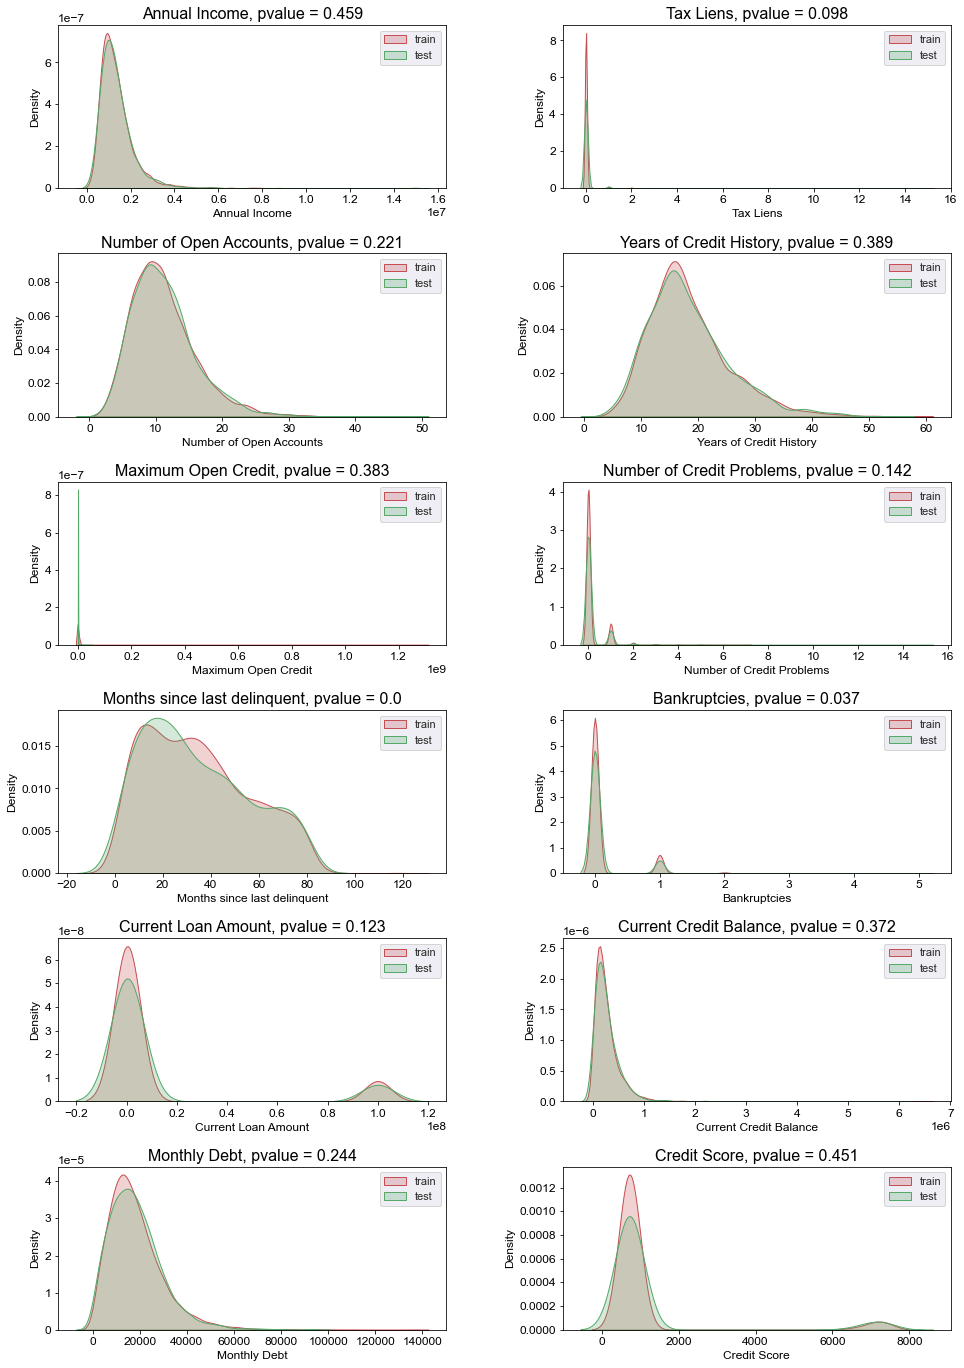

In [11]:
ds.plot_mannwhitneyu()

p-value меньше 5% оказалось у признаков: 
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства

#### Основные характеристики

In [12]:
ds.num_features.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,7.930000e+03,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,4561.000000,9983.000000,10000.0,1.000000e+04,10000.000000,7930.000000
mean,1.366525e+06,0.031400,11.144300,18.319614,8.865069e+05,0.168000,34.564568,0.114595,11943762.0,2.914740e+05,18303.660156,1171.992188
std,8.638284e+05,0.304333,4.894754,7.095358,1.389973e+07,0.514591,21.771950,0.349730,32008752.0,3.339973e+05,11831.619141,1639.814941
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000
25%,8.459892e+05,0.000000,8.000000,13.500000,2.788115e+05,0.000000,16.000000,0.000000,180548.5,1.132258e+05,10059.750000,711.000000
50%,1.168814e+06,0.000000,10.000000,17.000000,4.781810e+05,0.000000,32.000000,0.000000,311718.0,2.090190e+05,16200.000000,731.000000
75%,1.638693e+06,0.000000,14.000000,22.000000,7.943595e+05,0.000000,50.000000,0.000000,521070.0,3.619500e+05,23888.250000,743.000000
max,1.497561e+07,15.000000,48.000000,57.700001,1.304726e+09,15.000000,118.000000,5.000000,100000000.0,6.506797e+06,136679.000000,7510.000000


#### **Annual Income** - годовой доход

Заменим на медиану нулевые значения и значения больше 7500000

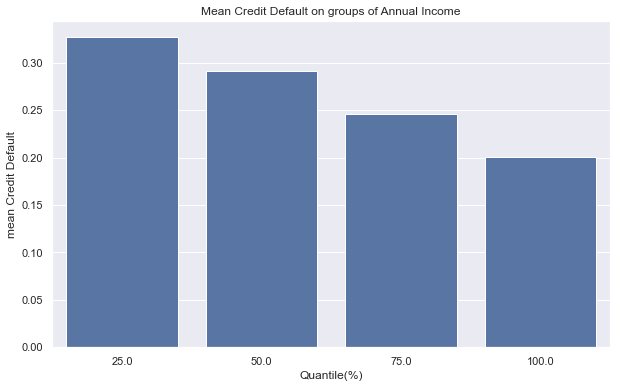

In [13]:
ds.plot_mean_of_groops('Annual Income', 'Credit Default', bins=4)

* Общая тенденция - чем выше годовой доход, тем меньше вероятность дефолта
* Построим зависимость среднего значения 'Annual Income' от значений 'Monthly Debt', разделив последний на 10 групп

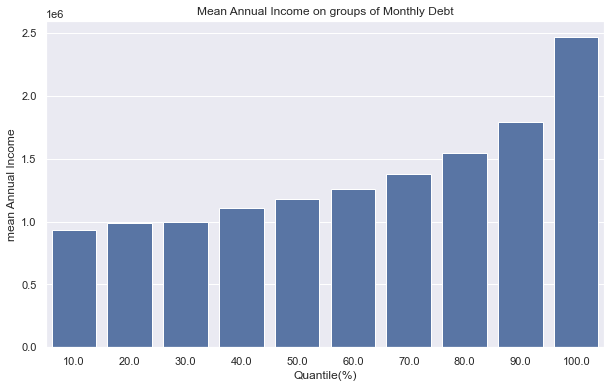

In [14]:
ds.plot_mean_of_groops('Monthly Debt','Annual Income', bins=10)

Значения 'Annual Income' более 6000000 считаем выбросами.

In [15]:
msk = (ds['Annual Income'] > 6000000) 
ds.loc[msk, 'Annual Income'] = None

#### **Maximum Open Credit** - наибольший открытый кредит

Больше 10000000 считаем выбросами

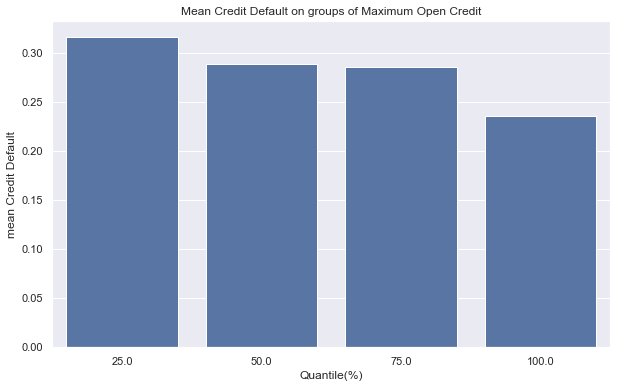

In [16]:
ds.plot_mean_of_groops('Maximum Open Credit', 'Credit Default', bins=4)

In [17]:
msk = (ds['Maximum Open Credit'] > 10000000) 
ds.loc[msk, 'Maximum Open Credit'] = None

#### **Number of Credit Problems** - количество проблем с кредитом

Возможно номинативный признак. 

In [18]:
ds['Number of Credit Problems'] = ds['Number of Credit Problems'].astype(np.uint8)

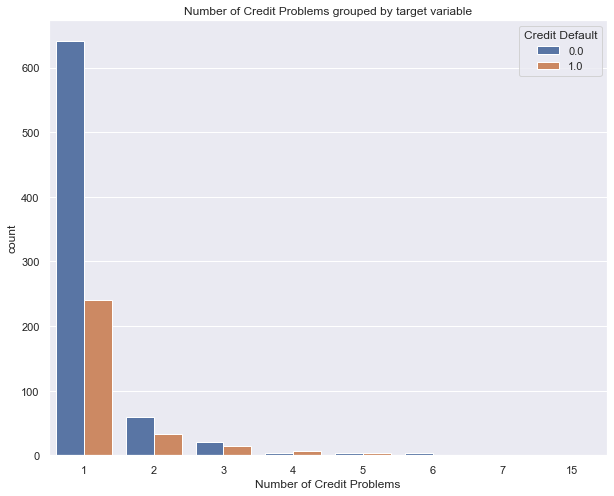

In [19]:
ds.plot_count_target('Number of Credit Problems', more_value=0)

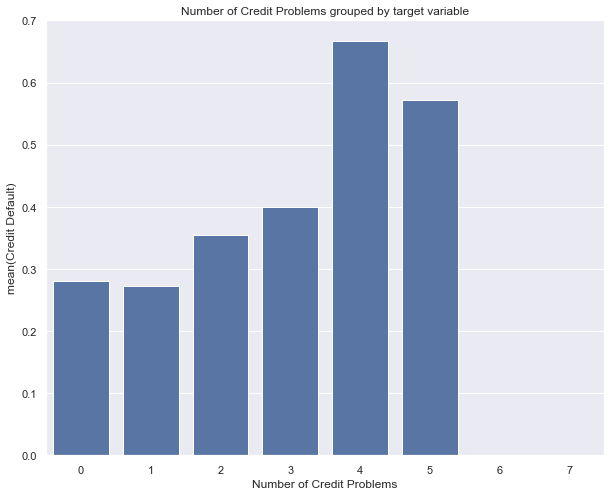

In [20]:
ds.train.plot_mean_target('Number of Credit Problems')

#### **Bankruptcies** - банкротства

Возможно номинативный признак.

In [21]:
ds['Bankruptcies'].value_counts()

0.0    8912
1.0    1020
2.0      36
3.0      10
4.0       3
5.0       2
Name: Bankruptcies, dtype: int64

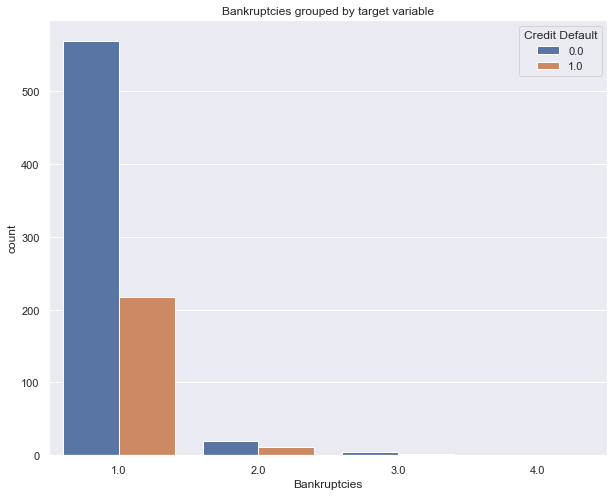

In [22]:
ds.train.plot_count_target('Bankruptcies', more_value=0)

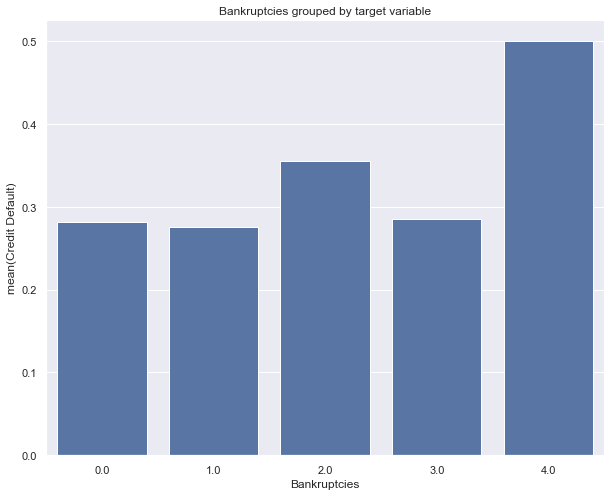

In [23]:
ds.train.plot_mean_target('Bankruptcies')

Значения больше 4 считаем выбросами

In [24]:
ds.loc[ds['Bankruptcies'] > 4, 'Bankruptcies'] = 0

**Current Loan Amount** - текущая сумма кредита

При значении 100 000 000 нет ни одного дефолта. Создадим отдельный бинарный признак  "Max Current Loan Amoun" со значением 1 для данных случаев.

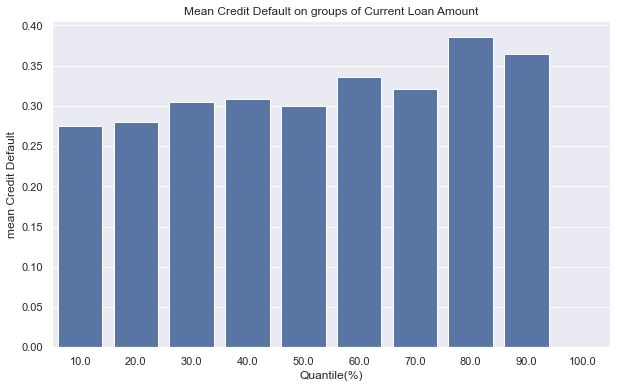

In [25]:
ds.train.plot_mean_of_groops('Current Loan Amount', 'Credit Default', bins=10)

In [26]:
ds['No Default Current Loan Amount'] = 0
ds['No Default Current Loan Amount'] = ds['No Default Current Loan Amount'].astype(np.int8)
msk = ds['Current Loan Amount'] == 100000000
ds.loc[msk, 'No Default Current Loan Amount'] = 1
ds.loc[msk, 'Current Loan Amount'] = None

Больше 750000 будем считать выбросами

In [27]:
msk = ds['Current Loan Amount'] > 750000
ds.loc[msk, 'Current Loan Amount'] = None

**Current Credit Balance** - текущий кредитный баланс

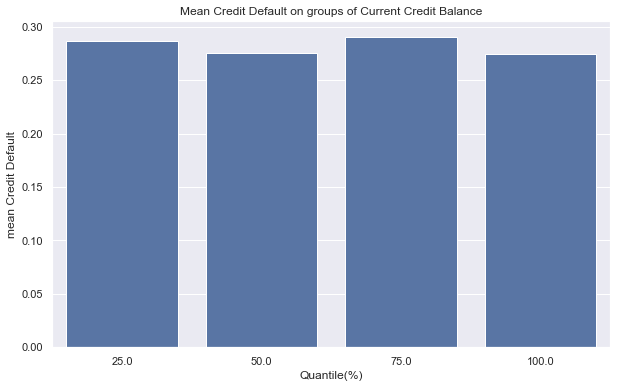

In [28]:
ds.train.plot_mean_of_groops('Current Credit Balance', 'Credit Default', bins=4)

Значения больше 500000 будем считать выбросами

In [29]:
msk = ds['Current Credit Balance'] > 500000
ds.loc[msk, 'Current Credit Balance'] = None

**Monthly Debt** - ежемесячный долг

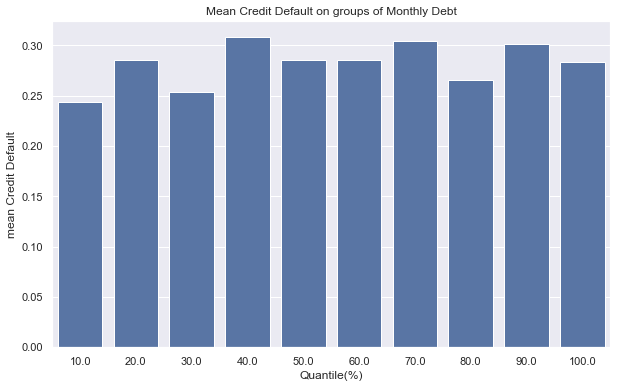

In [30]:
ds.train.plot_mean_of_groops('Monthly Debt', 'Credit Default', bins=10)

Значения меньше 100 и больше 750000 будем считать выбросами

In [31]:
msk = ds['Monthly Debt']  < 100
ds.loc[msk, 'Monthly Debt'] = None

msk = ds['Monthly Debt']  > 750000
ds.loc[msk, 'Monthly Debt'] = None

**Credit Score** - баллы кредитного рейтинга

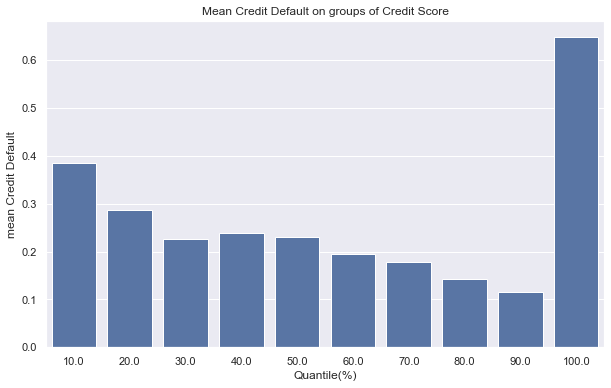

In [32]:
ds.train.plot_mean_of_groops('Credit Score', 'Credit Default', bins=10)

У всех записей в обучающей выборке со значением 'Credit Score' больше 2000 значение 'Credit Default' равно 1. 
Добавим бинарный признак для данных записей, а их значение 'Credit Score' уменьшим в 10 раз.

In [33]:
ds['Default Credit Score'] = 1
msk = ds['Credit Score'] > 2000
ds.loc[msk, 'Default Credit Score'] = 0
ds.loc[msk, 'Credit Score'] = ds.loc[msk, 'Credit Score'] / 10.0
#ds.loc[msk, 'Credit Score'] = None

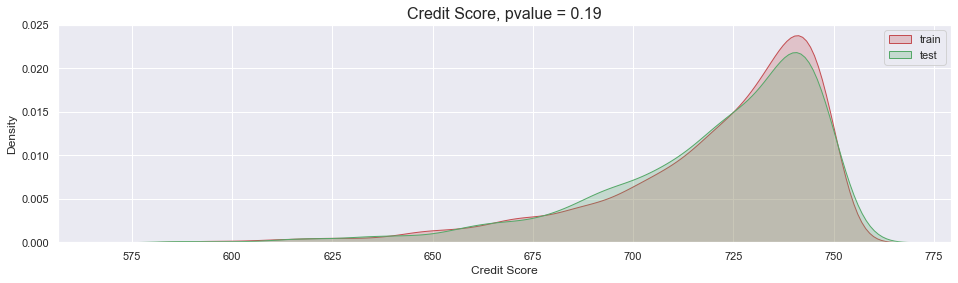

In [34]:
ds.plot_mannwhitneyu(feature_names=['Credit Score'])

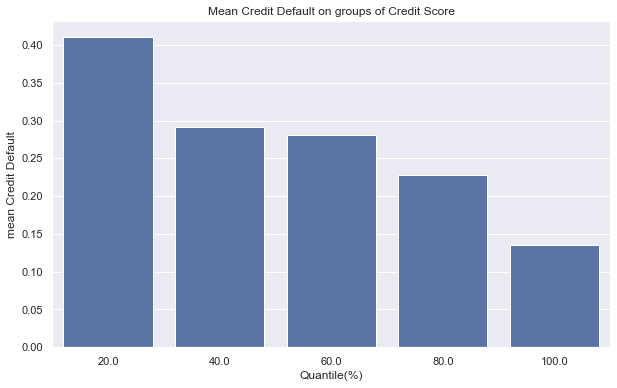

In [35]:
ds.train.plot_mean_of_groops('Credit Score', 'Credit Default', bins=5)

### 2.2.2 Номинативные признаки

In [36]:
ds_obj_features = ds.select_dtypes(include=['category','object'])
ds_obj_features.head()

Home Ownership Years in current job             Purpose        Term
Part  Id                                                                    
train 0        Own Home                  NaN  debt consolidation  Short Term
      1        Own Home            10+ years  debt consolidation   Long Term
      2   Home Mortgage              8 years  debt consolidation  Short Term
      3        Own Home              6 years  debt consolidation  Short Term
      4            Rent              8 years  debt consolidation  Short Term

**Term** - срок кредита

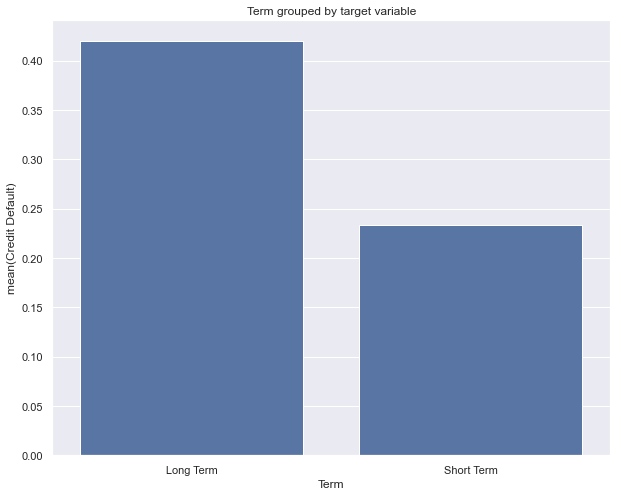

In [37]:
ds.train.plot_mean_target('Term')

In [38]:
ds['Term'].value_counts()

Short Term    7417
Long Term     2583
Name: Term, dtype: int64

### 2.2.3 Заполним пустые значения

**Monthly Debt** - ежемесячный долг

In [39]:
ds.feature_encoding(base_feature='Annual Income', 
                    trgt_feature='Monthly Debt', 
                    new_feature='Monthly Debt encoding Annual Income', 
                    bins=10)

msk = ds['Monthly Debt'].isnull()
ds.loc[msk, 'Monthly Debt'] = ds.loc[msk, 'Monthly Debt encoding Annual Income']

**Annual Income** - годовой доход

Заменяем выбросы и нулевые значения на средние значения 'Monthly Debt' по группам

In [40]:
ds.feature_encoding(base_feature='Monthly Debt', 
                    trgt_feature='Annual Income', 
                    new_feature='Annual Income encoding Monthly Debt', 
                    bins=10)
msk = ds['Annual Income'].isnull()
ds.loc[msk, 'Annual Income'] = ds.loc[msk, 'Annual Income encoding Monthly Debt']

**Maximum Open Credit** - наибольший открытый кредит

In [41]:
msk = ds['Maximum Open Credit'].isnull()
ds.loc[msk, 'Maximum Open Credit'] = ds['Maximum Open Credit'].mean()

**Bankruptcies** - банкротства

In [42]:
ds.loc[ds['Bankruptcies'].isnull(), 'Bankruptcies'] = 0
ds['Bankruptcies'] = ds['Bankruptcies'].astype(np.uint8)

**Current Loan Amount** - текущая сумма кредита

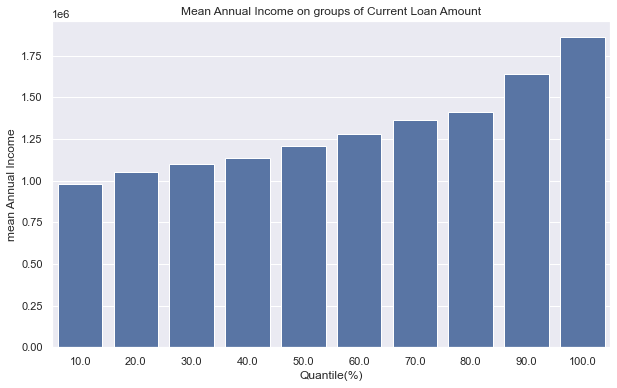

In [43]:
ds.plot_mean_of_groops('Current Loan Amount', 'Annual Income', bins=10)

ds.feature_encoding(base_feature='Annual Income', 
                    trgt_feature='Current Loan Amount', 
                    new_feature='Current Loan Amount encoding Annual Income', 
                    bins=10)

In [44]:
msk = ds['Current Loan Amount'].isnull()
ds.loc[msk, 'Current Loan Amount'] = ds.loc[msk, 'Current Loan Amount encoding Annual Income']

**Current Credit Balance** - текущий кредитный баланс

In [45]:
ds.feature_encoding(base_feature='Monthly Debt', 
                    trgt_feature='Current Credit Balance', 
                    new_feature='Current Credit Balance encoding Monthly Debt', 
                    bins=10)

In [46]:
msk = ds['Current Credit Balance'].isnull()
ds.loc[msk, 'Current Credit Balance'] = ds.loc[msk, 'Current Credit Balance encoding Monthly Debt']

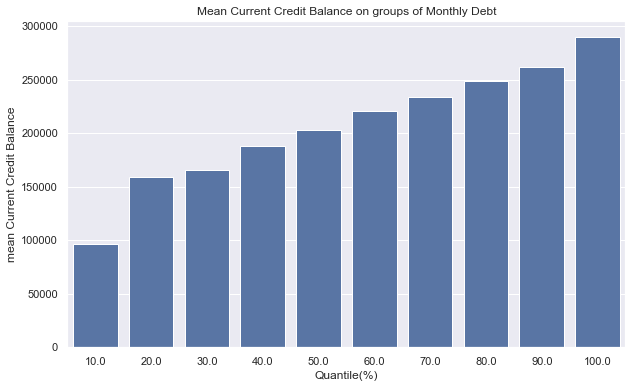

In [47]:
ds.plot_mean_of_groops('Monthly Debt', 'Current Credit Balance',  bins=10)

**Credit Score** - баллы кредитного рейтинга

Заполним пустые значения медианой

In [48]:
msk = ds['Credit Score'].isnull()
ds.loc[msk, 'Credit Score'] = ds['Credit Score'].median()

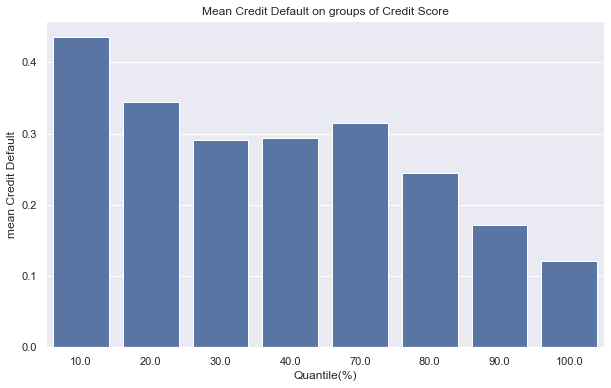

In [49]:
ds.train.plot_mean_of_groops('Credit Score', 'Credit Default', bins=10)

In [50]:
ds['Credit Score < mean'] = 0
msk = ds['Credit Score'] > ds['Credit Score'].median()
ds.loc[msk, 'Credit Score < mean'] = 1 

# Шаг 3. Обучение модели

In [51]:
feature_names = [
                'Annual Income',                          
                'Maximum Open Credit',                    
                'Number of Credit Problems',
                'Bankruptcies',                          
                'Current Loan Amount',                    
                'No Default Current Loan Amount',         
                'Current Credit Balance',   #              
                'Credit Score',                           
                'Default Credit Score',                   
                'Term',                                   
                ]

cat_features = [
                'Number of Credit Problems',
                'Bankruptcies',
                'No Default Current Loan Amount',
                'Default Credit Score',
                'Term',
              ]

X_train, X_test, y_train, y_test = ds.train.train_test_split(feature_names)
print(X_train.shape, X_test.shape)

model_cb = catb_fit_predict(X_train, X_test, y_train, y_test, cat_features)

(6000, 10) (1500, 10)
Train
              precision    recall  f1-score   support

         0.0       0.89      0.65      0.76      4310
         1.0       0.48      0.80      0.60      1690

    accuracy                           0.70      6000
   macro avg       0.69      0.73      0.68      6000
weighted avg       0.78      0.70      0.71      6000

Test
              precision    recall  f1-score   support

         0.0       0.86      0.63      0.73      1077
         1.0       0.44      0.75      0.56       423

    accuracy                           0.66      1500
   macro avg       0.65      0.69      0.64      1500
weighted avg       0.75      0.66      0.68      1500



# Шаг 4. Предсказываем и сохраняем результат

In [52]:
X_predict = ds.test[feature_names]
y_predict = model_cb.predict(X_predict)
df_predict = pd.DataFrame(y_predict, columns=['Credit Default'])
df_predict.index.names=['Id']
df_predict['Credit Default'] = df_predict['Credit Default'].astype(np.uint8)

In [53]:
df_predict.to_csv("sample_submission.csv", sep=',')
df = pd.read_csv("sample_submission.csv", ',')
df.head(5)

,Id,Credit Default
0,0,1
1,1,0
2,2,1
3,3,0
4,4,1
